In [5]:
import symnum
import symnum.numpy as snp
import simsde
import sympy
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [6]:
def drift_func(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -snp.exp(log_I + log_C) / N - snp.exp(log_I + log_C - log_S) / (2 * N),
        snp.exp(log_S + log_C) / N 
        - snp.exp(log_S + log_C - log_I) / (2 * N) 
        - (λ / 2) * snp.exp(-log_I) - λ,
        α * (β - log_C)
    ])

def diff_coeff(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), 0, 0],
        [
            -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 
            snp.sqrt(λ) * snp.exp(-log_I / 2), 
            0
        ],
        [0, 0, σ]
    ])
    

def diff_coeff_second(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 0],
        [0, snp.sqrt(λ) * snp.exp(-log_I / 2), 0],
        [0, 0, σ]
    ])
    
dim_x = 3
dim_w = 3
dim_θ = 5

v = [drift_func] + [simsde.operators.subscript_k(diff_coeff, k) for k in range(dim_x)]
x = snp.array(sympy.symbols('log_S, log_I, log_C'))
θ = snp.array(sympy.symbols('α, β, σ, λ, N'))
display(v[2](x, θ))

[-exp(log_C/2 - log_I/2 + log_S/2)/sqrt(N), sqrt(λ)*exp(-log_I/2), 0]

Text(0.5, 0, 'Time')

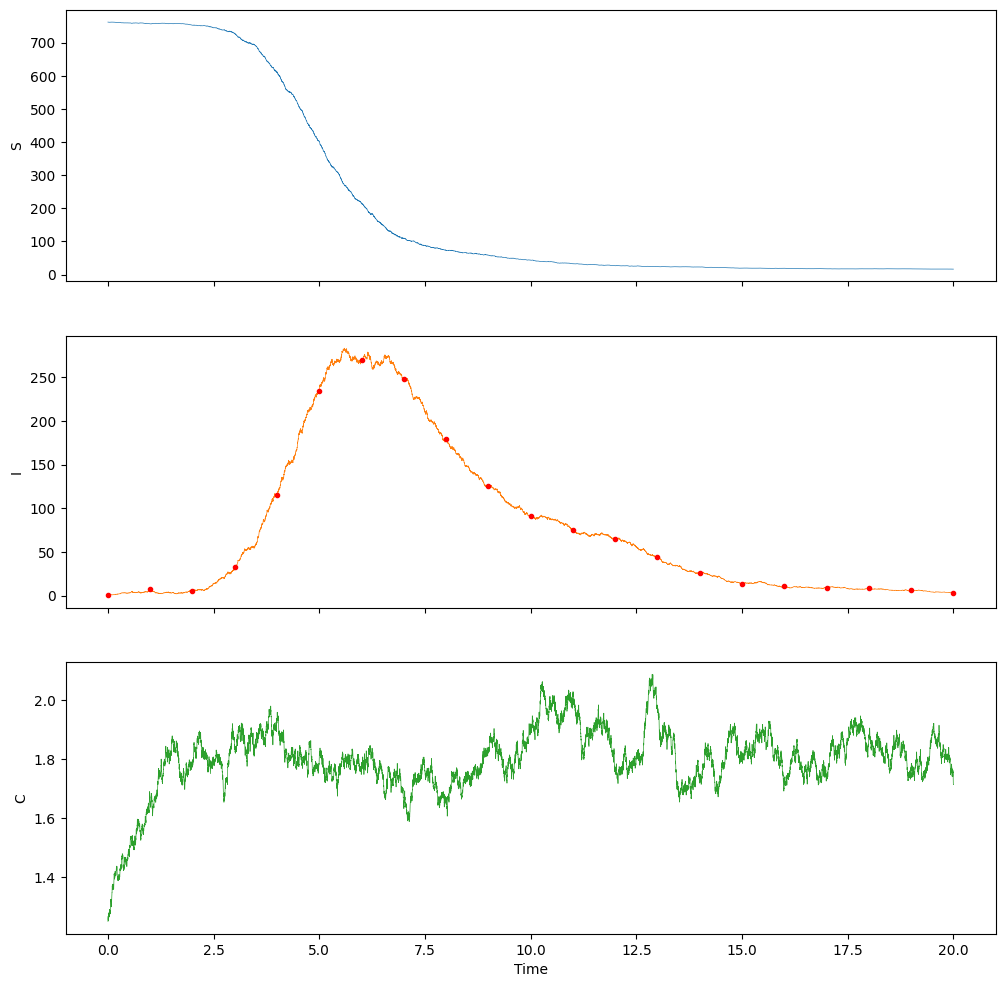

In [7]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763.,  # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])
    
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff, diff_coeff_second),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.001 
t_max = 13.
dt_observation = 1.
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

#simulation_method = "weak_order_2"
simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
#obs_noise_std = 10.
obs_noise_std = 0.4
x_0_obs = np.log(np.array([762., 1., 1.25]))
#θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
θ_obs = np.array([2.04, 0.592, 0.10, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)
y_obs = np.array([3, 8, 28, 75, 221, 281, 255, 235, 190, 125, 70, 28, 12, 5])

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, np.exp(x_seq_obs[:, i]), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[1].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.2


Sampling stage: Adaptive warm up [02:53] > Main non-adaptive [06:45]

Chain 1/4: 100%|██████████|1000/1000 [01:39<00:00, 10.02it/s, n_step=997., accept_stat=0.828]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [01:42<00:00, 9.78it/s, n_step=1.02e+03, accept_stat=0.883]

Chain 3/4: 100%|██████████|1000/1000 [01:41<00:00, 9.86it/s, n_step=1.01e+03, accept_stat=0.872]

Chain 4/4: 100%|██████████|1000/1000 [01:41<00:00, 9.83it/s, n_step=1.02e+03, accept_stat=0.876]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.956,1.017,0.053,2.834,0.179,0.128,25.0,152.0,1.17
β,0.301,0.240,-0.166,0.668,0.031,0.022,54.0,112.0,1.10
σ,0.185,0.195,0.003,0.537,0.042,0.030,15.0,51.0,1.19
λ,0.495,0.024,0.447,0.536,0.005,0.003,31.0,68.0,1.10
x_0_2,0.640,0.587,-0.806,1.578,0.135,0.097,24.0,116.0,1.13


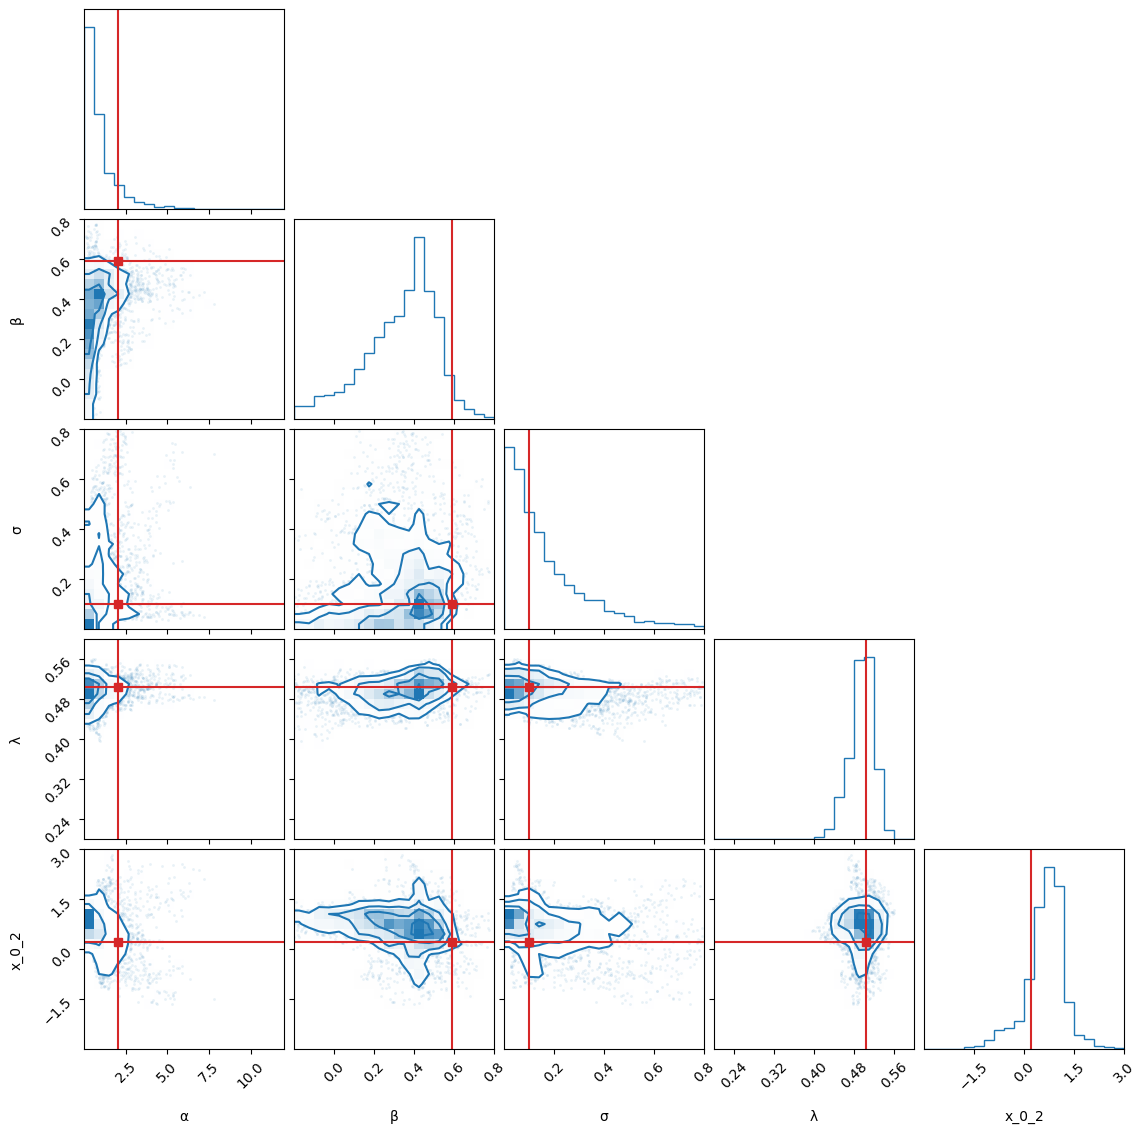

weak_order_2
0.2


Sampling stage: Adaptive warm up [03:55] > Main non-adaptive [09:08]

Chain 1/4: 100%|██████████|1000/1000 [02:16<00:00, 7.33it/s, n_step=1.00e+03, accept_stat=0.812]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:17<00:00, 7.29it/s, n_step=1.01e+03, accept_stat=0.815]

Chain 3/4: 100%|██████████|1000/1000 [02:17<00:00, 7.29it/s, n_step=1.01e+03, accept_stat=0.818]

Chain 4/4: 100%|██████████|1000/1000 [02:18<00:00, 7.23it/s, n_step=1.02e+03, accept_stat=0.842]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.338,1.325,0.074,3.712,0.132,0.093,70.0,166.0,1.05
β,0.477,0.170,0.155,0.739,0.020,0.014,82.0,114.0,1.06
σ,0.076,0.079,0.004,0.195,0.008,0.006,66.0,249.0,1.07
λ,0.472,0.018,0.438,0.502,0.002,0.001,101.0,150.0,1.03
x_0_2,0.456,0.636,-0.996,1.395,0.067,0.048,95.0,186.0,1.05


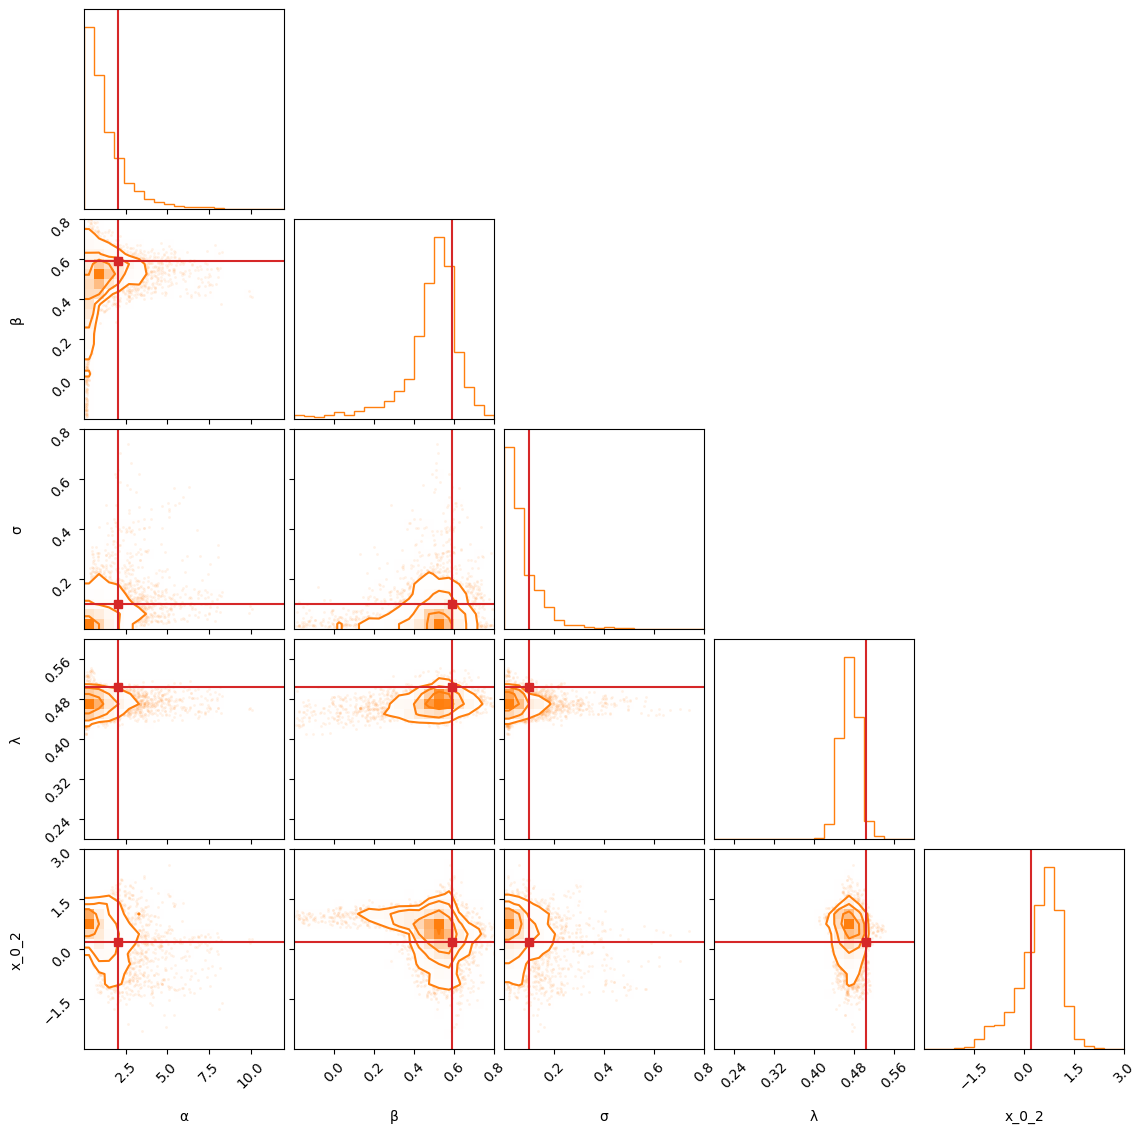

euler_maruyama
0.16


Sampling stage: Adaptive warm up [02:53] > Main non-adaptive [05:20]

Chain 1/4: 100%|██████████|1000/1000 [00:02<00:00, 415.47it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [01:45<00:00, 9.43it/s, n_step=1.02e+03, accept_stat=0.924]

Chain 3/4: 100%|██████████|1000/1000 [01:46<00:00, 9.42it/s, n_step=1.02e+03, accept_stat=0.907]

Chain 4/4: 100%|██████████|1000/1000 [01:46<00:00, 9.41it/s, n_step=1.02e+03, accept_stat=0.950]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.684,0.827,0.065,1.561,0.204,0.147,17.0,18.0,1.63
β,0.272,0.255,-0.059,0.693,0.083,0.061,10.0,43.0,1.33
σ,0.115,0.087,0.002,0.255,0.030,0.022,7.0,39.0,1.53
λ,0.526,0.032,0.477,0.569,0.013,0.010,7.0,112.0,1.64
x_0_2,0.383,0.693,-0.519,1.452,0.291,0.218,7.0,4.0,1.61


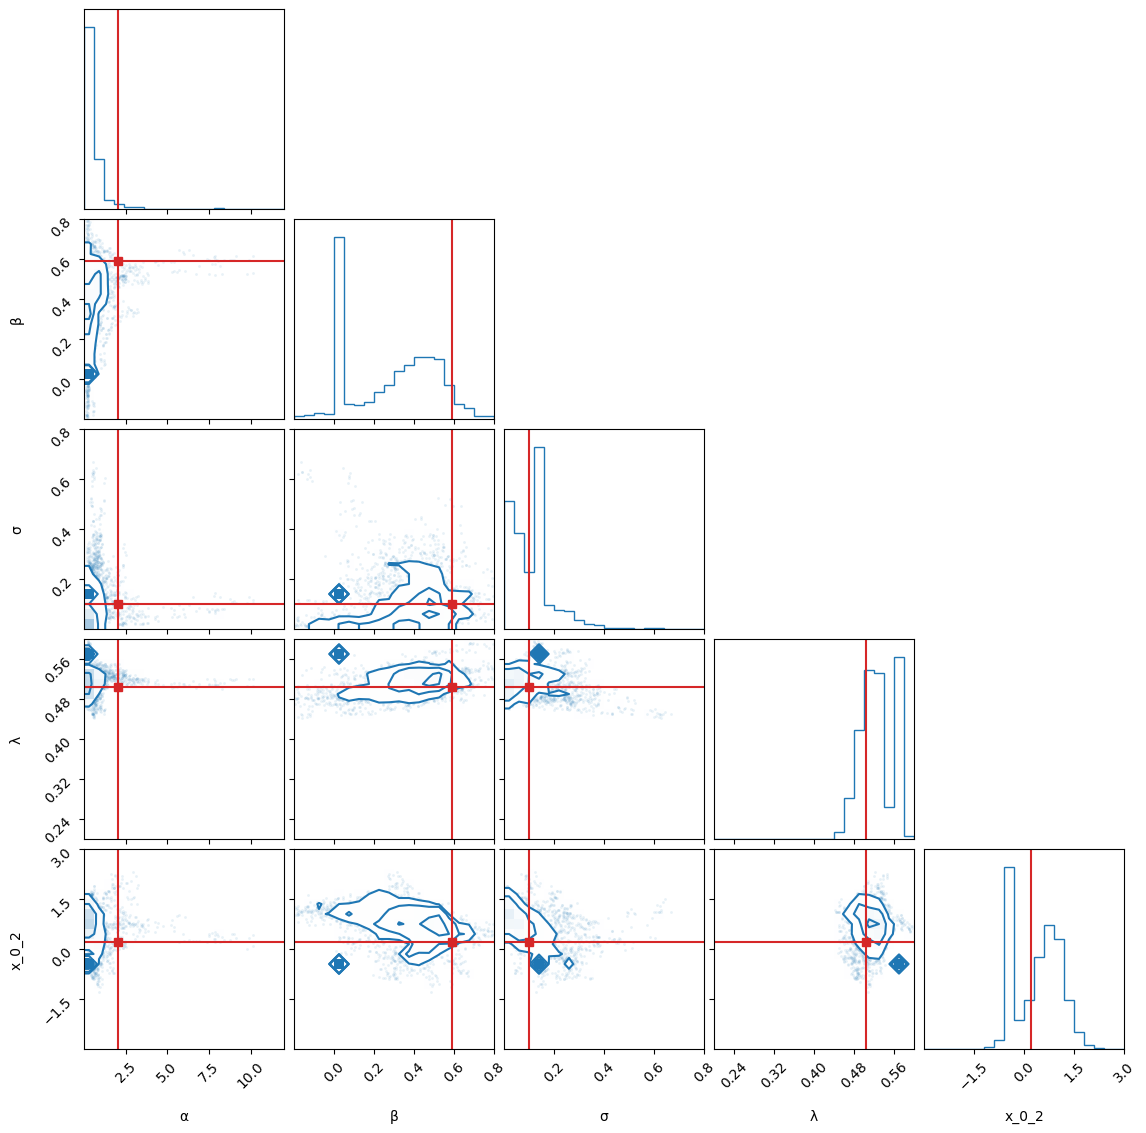

weak_order_2
0.16


Sampling stage: Adaptive warm up [04:26] > Main non-adaptive [07:43]

Chain 1/4: 100%|██████████|1000/1000 [02:33<00:00, 6.50it/s, n_step=1.02e+03, accept_stat=0.910]

Chain 2/4: 100%|██████████|1000/1000 [02:33<00:00, 6.51it/s, n_step=1.02e+03, accept_stat=0.914]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [00:02<00:00, 406.43it/s, n_step=1.00, accept_stat=0.00]

Chain 4/4: 100%|██████████|1000/1000 [02:33<00:00, 6.50it/s, n_step=1.02e+03, accept_stat=0.941]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.473,1.663,0.068,4.747,0.418,0.301,16.0,58.0,1.18
β,0.438,0.241,0.170,0.778,0.083,0.068,11.0,5.0,1.29
σ,0.087,0.070,0.005,0.198,0.010,0.007,23.0,87.0,1.16
λ,0.541,0.095,0.459,0.703,0.047,0.036,6.0,35.0,1.80
x_0_2,0.526,0.530,-0.632,1.430,0.119,0.085,21.0,143.0,1.58


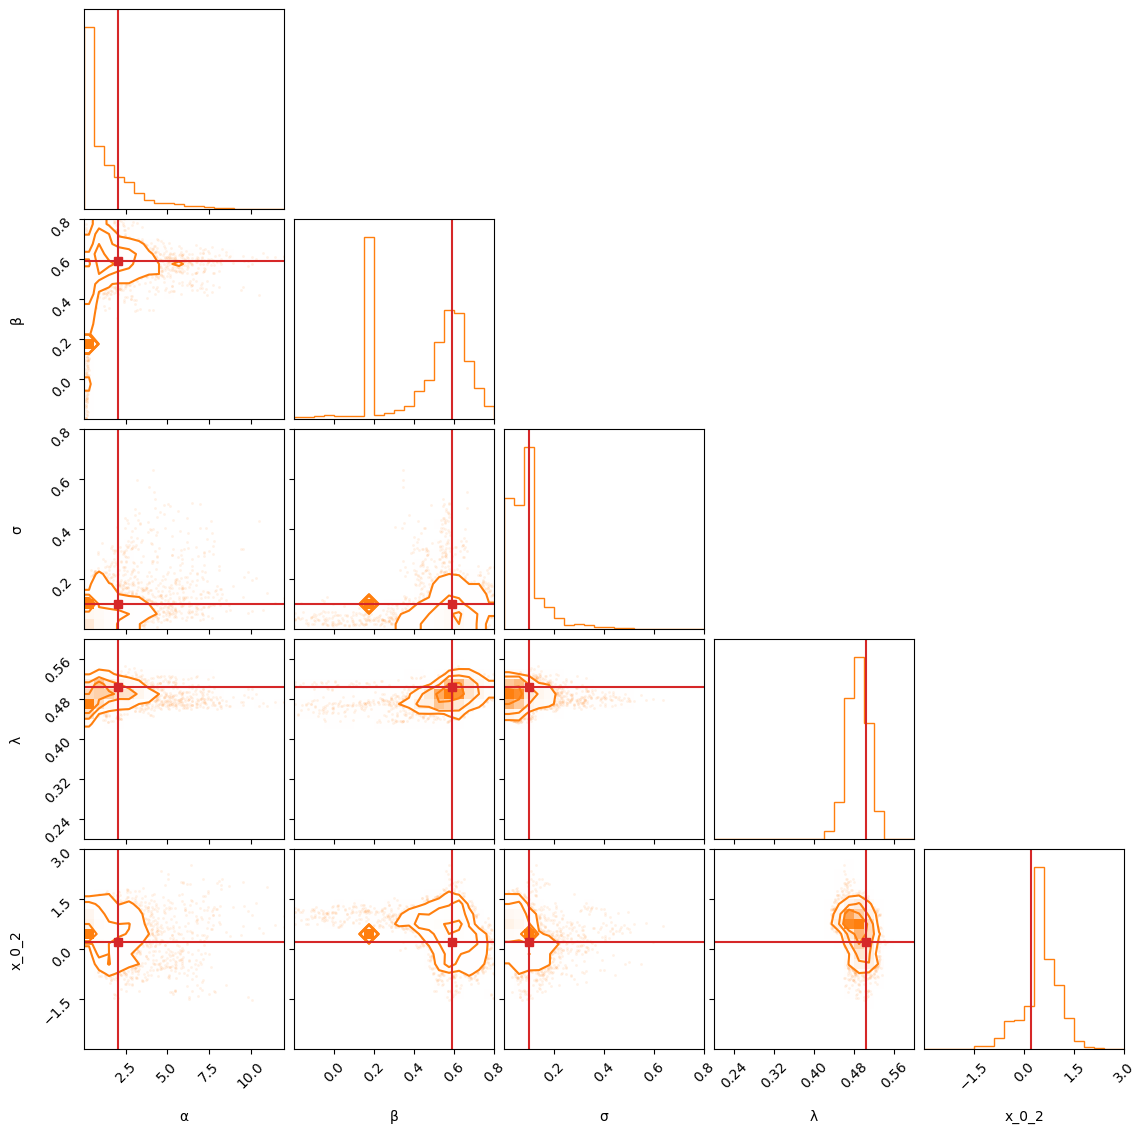

euler_maruyama
0.12


Sampling stage: Adaptive warm up [03:21] > Main non-adaptive [05:36]

Chain 1/4: 100%|██████████|1000/1000 [00:02<00:00, 354.07it/s, n_step=4.56, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [01:51<00:00, 9.00it/s, n_step=996., accept_stat=0.826]

Chain 3/4: 100%|██████████|1000/1000 [01:50<00:00, 9.03it/s, n_step=993., accept_stat=0.847]

Chain 4/4: 100%|██████████|1000/1000 [01:52<00:00, 8.92it/s, n_step=1.00e+03, accept_stat=0.829]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.019,1.104,0.047,2.851,0.246,0.177,9.0,23.0,1.41
β,0.384,0.216,-0.059,0.707,0.049,0.040,15.0,32.0,1.21
σ,0.146,0.197,0.003,0.519,0.048,0.035,9.0,72.0,1.39
λ,0.502,0.019,0.476,0.546,0.005,0.004,16.0,96.0,1.22
x_0_2,0.754,0.730,-0.507,1.603,0.276,0.232,7.0,17.0,1.64


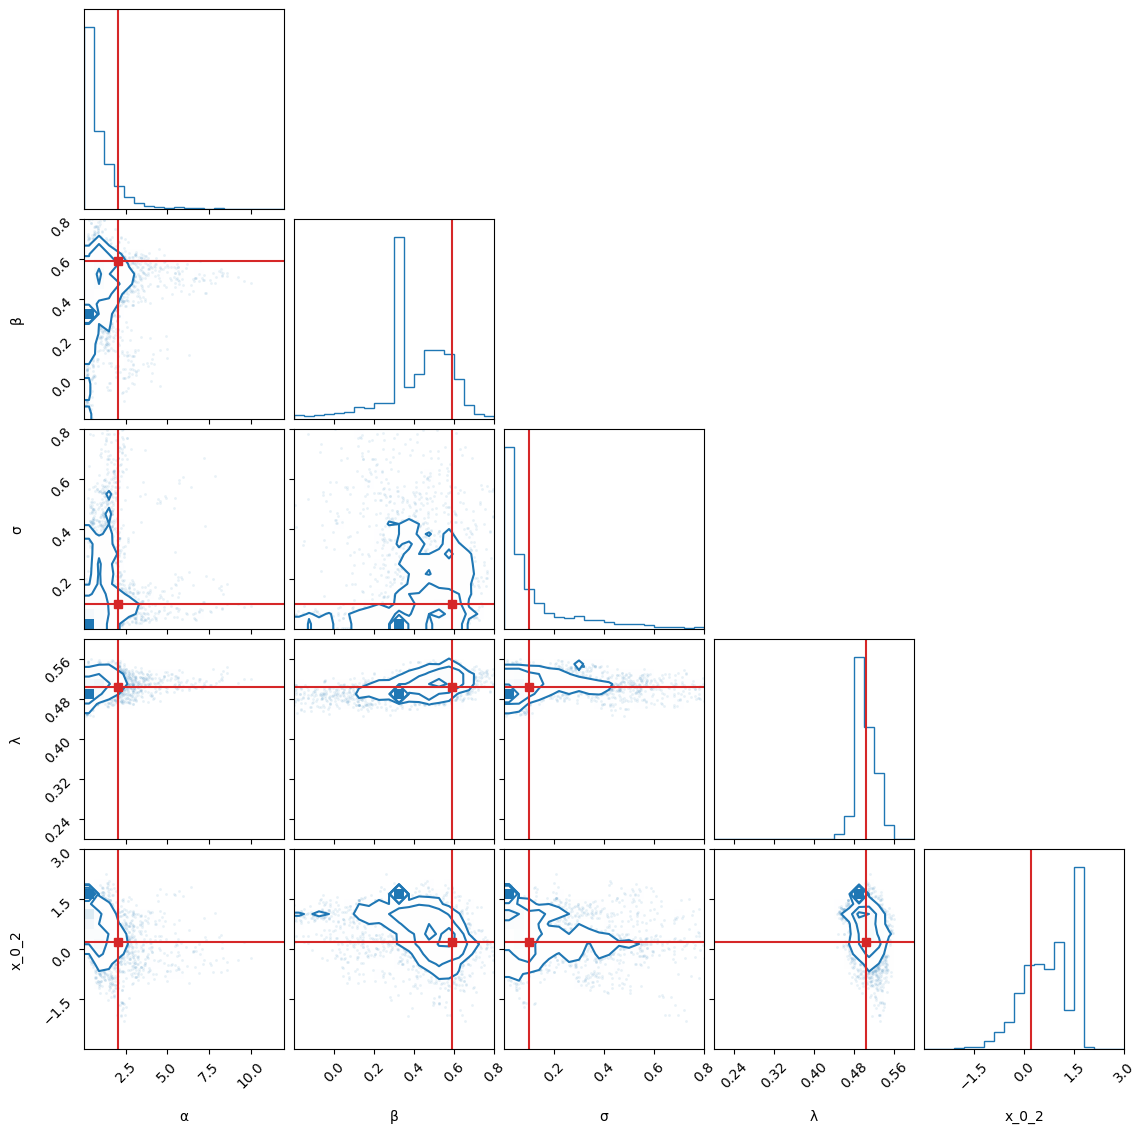

weak_order_2
0.12


Sampling stage: Adaptive warm up [04:54] > Main non-adaptive [03:02]

Chain 1/4: 100%|██████████|1000/1000 [00:02<00:00, 402.16it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:54<00:00, 5.73it/s, n_step=1.02e+03, accept_stat=0.996]

Chain 3/4: 100%|██████████|1000/1000 [00:02<00:00, 399.88it/s, n_step=1.00, accept_stat=0.00]

Chain 4/4: 100%|██████████|1000/1000 [00:02<00:00, 389.36it/s, n_step=1.32, accept_stat=0.00]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.535,0.988,0.752,3.670,0.437,0.329,4.0,4.0,3.44
β,0.671,0.177,0.479,0.903,0.088,0.067,5.0,49.0,2.96
σ,0.091,0.081,0.025,0.170,0.034,0.025,5.0,22.0,2.53
λ,0.496,0.020,0.471,0.527,0.010,0.008,4.0,4.0,3.93
x_0_2,0.277,0.761,-0.562,1.603,0.370,0.282,4.0,4.0,3.91


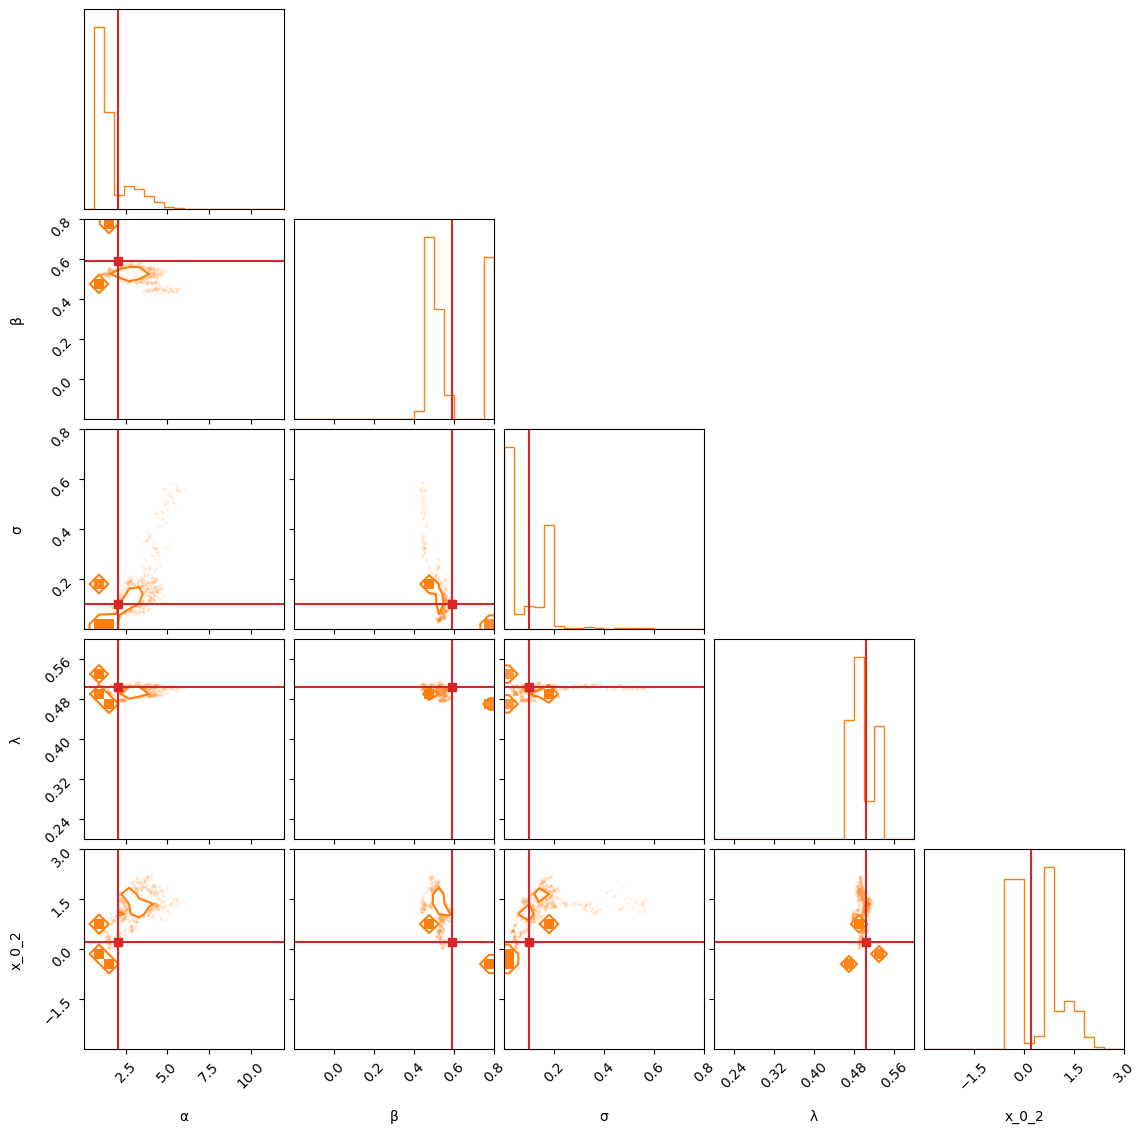

euler_maruyama
0.1


Sampling stage: Adaptive warm up [03:34] > Main non-adaptive [02:06]

Chain 1/4: 100%|██████████|1000/1000 [00:02<00:00, 411.95it/s, n_step=1.00, accept_stat=0.00]

Chain 2/4: 100%|██████████|1000/1000 [00:02<00:00, 410.61it/s, n_step=1.00, accept_stat=0.00]

Chain 3/4: 100%|██████████|1000/1000 [00:02<00:00, 410.47it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [01:59<00:00, 8.39it/s, n_step=1.02e+03, accept_stat=0.994]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.508,0.222,0.101,0.736,0.103,0.081,5.0,12.0,2.89
β,0.727,0.645,-0.338,1.381,0.316,0.246,4.0,12.0,4.40
σ,0.076,0.068,0.013,0.183,0.034,0.026,5.0,22.0,4.21
λ,0.518,0.035,0.463,0.569,0.017,0.013,4.0,17.0,4.73
x_0_2,-0.074,0.744,-0.874,1.146,0.367,0.280,4.0,4.0,4.59


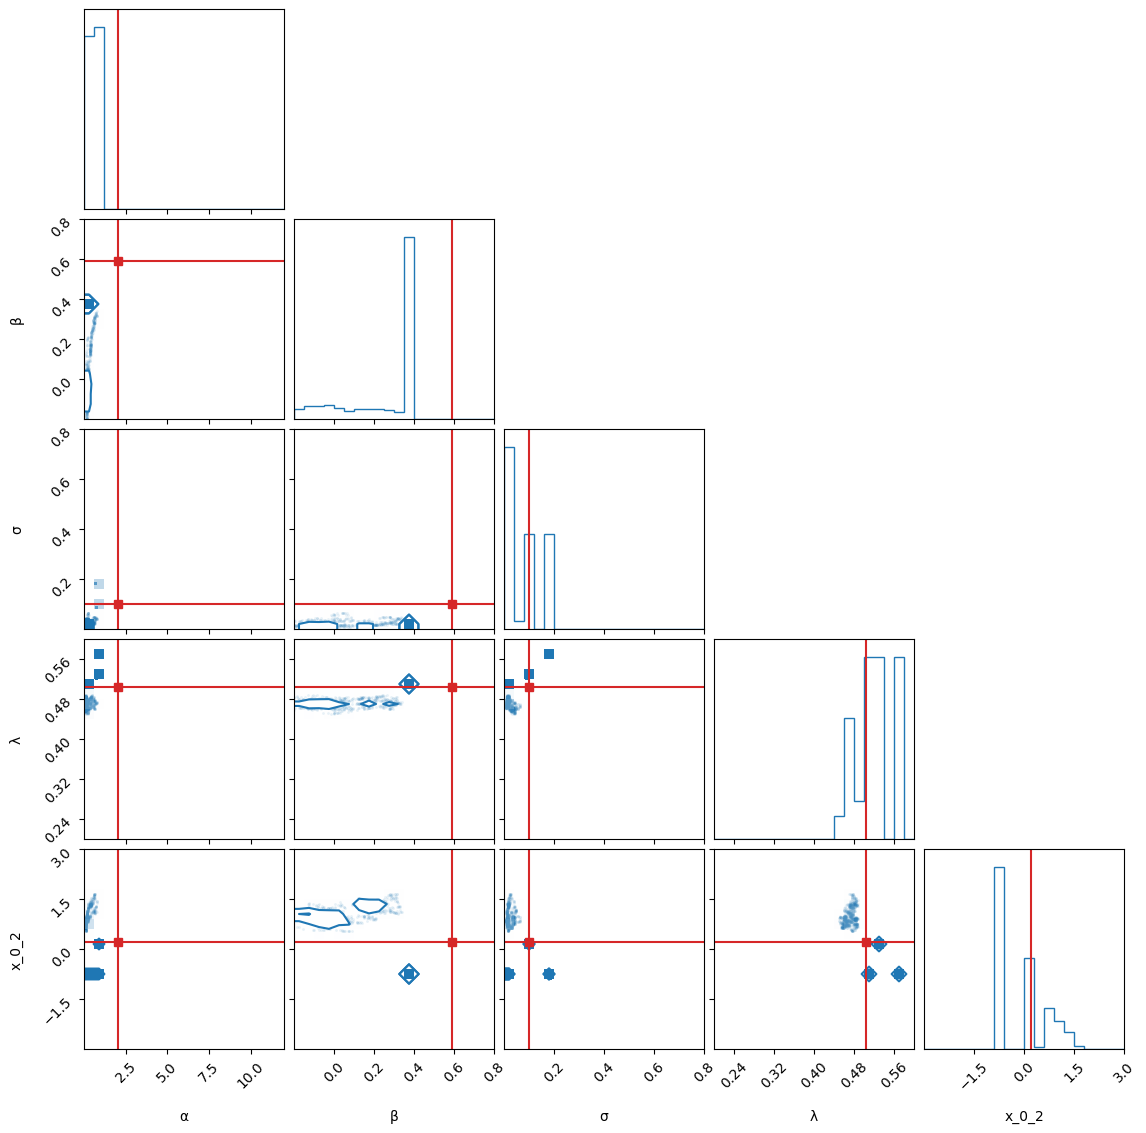

weak_order_2
0.1


Sampling stage: Adaptive warm up [05:52] > Main non-adaptive [06:32]

Chain 1/4: 100%|██████████|1000/1000 [03:13<00:00, 5.17it/s, n_step=1.02e+03, accept_stat=0.951]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [00:02<00:00, 395.56it/s, n_step=1.00, accept_stat=0.00]

Chain 3/4: 100%|██████████|1000/1000 [00:03<00:00, 333.10it/s, n_step=3.55, accept_stat=0.00]

Chain 4/4: 100%|██████████|1000/1000 [03:13<00:00, 5.16it/s, n_step=1.02e+03, accept_stat=0.946]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.689,1.823,0.234,4.505,0.488,0.353,7.0,32.0,1.60
β,0.469,0.088,0.369,0.630,0.036,0.027,6.0,51.0,1.80
σ,0.213,0.249,0.019,0.607,0.117,0.088,7.0,76.0,1.59
λ,0.475,0.026,0.445,0.507,0.011,0.008,6.0,62.0,1.75
x_0_2,0.796,0.678,-0.806,1.494,0.244,0.189,8.0,63.0,1.66


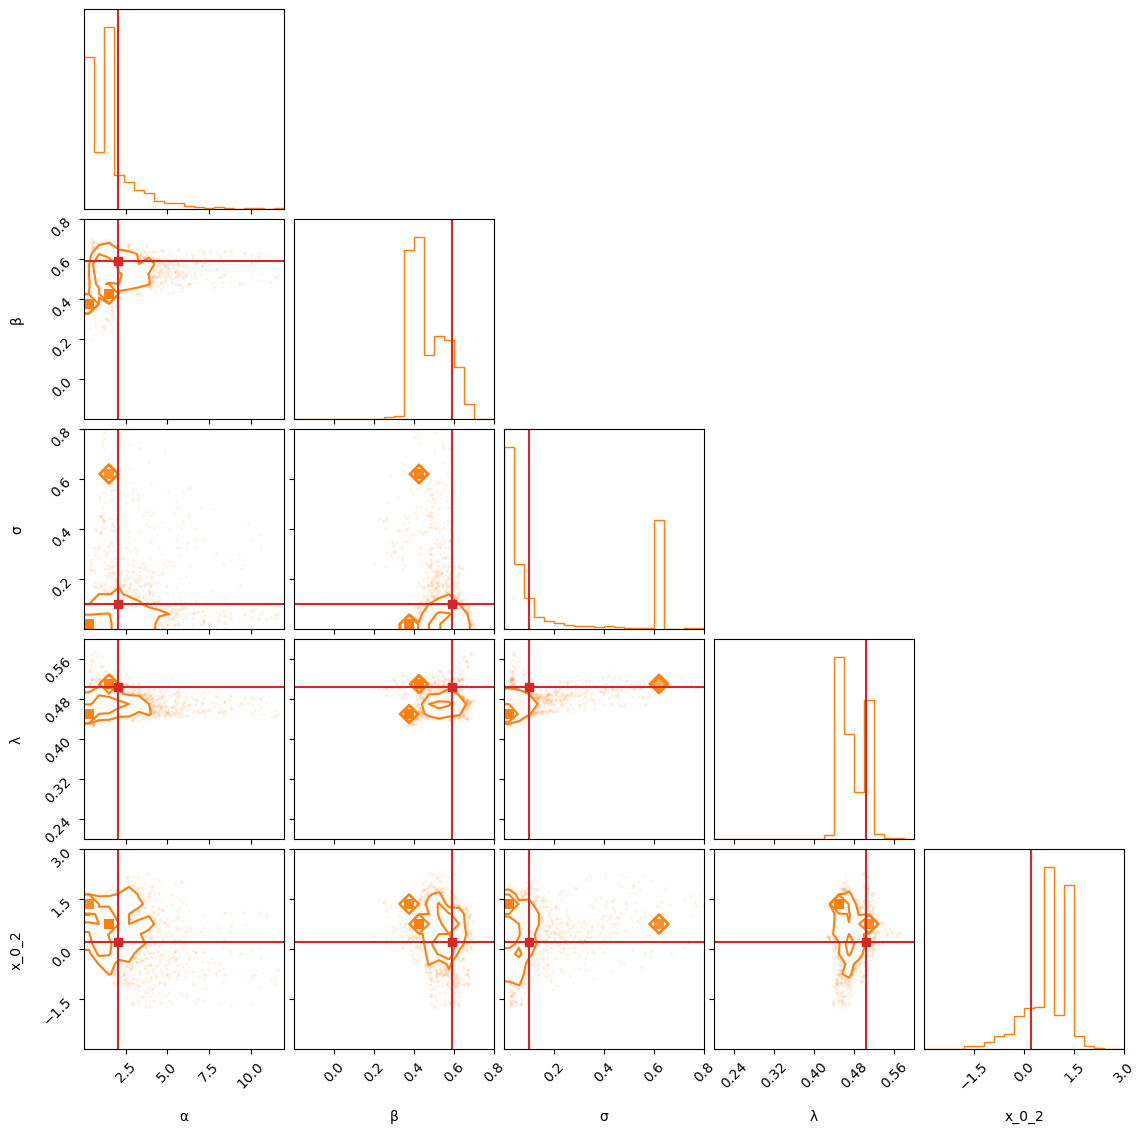

euler_maruyama
0.08


Sampling stage: Adaptive warm up [03:42] > Main non-adaptive [08:22]

Chain 1/4: 100%|██████████|1000/1000 [02:05<00:00, 7.95it/s, n_step=1.02e+03, accept_stat=0.848]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:06<00:00, 7.93it/s, n_step=1.02e+03, accept_stat=0.863]

Chain 3/4: 100%|██████████|1000/1000 [02:03<00:00, 8.11it/s, n_step=999., accept_stat=0.797]

Chain 4/4: 100%|██████████|1000/1000 [02:06<00:00, 7.89it/s, n_step=1.02e+03, accept_stat=0.831]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.902,2.349,0.046,6.213,0.241,0.171,47.0,55.0,1.09
β,0.504,0.159,0.202,0.754,0.016,0.011,90.0,190.0,1.07
σ,0.102,0.097,0.004,0.274,0.009,0.006,73.0,118.0,1.05
λ,0.508,0.023,0.463,0.549,0.002,0.002,83.0,177.0,1.03
x_0_2,0.444,0.658,-0.833,1.603,0.079,0.056,91.0,196.0,1.03


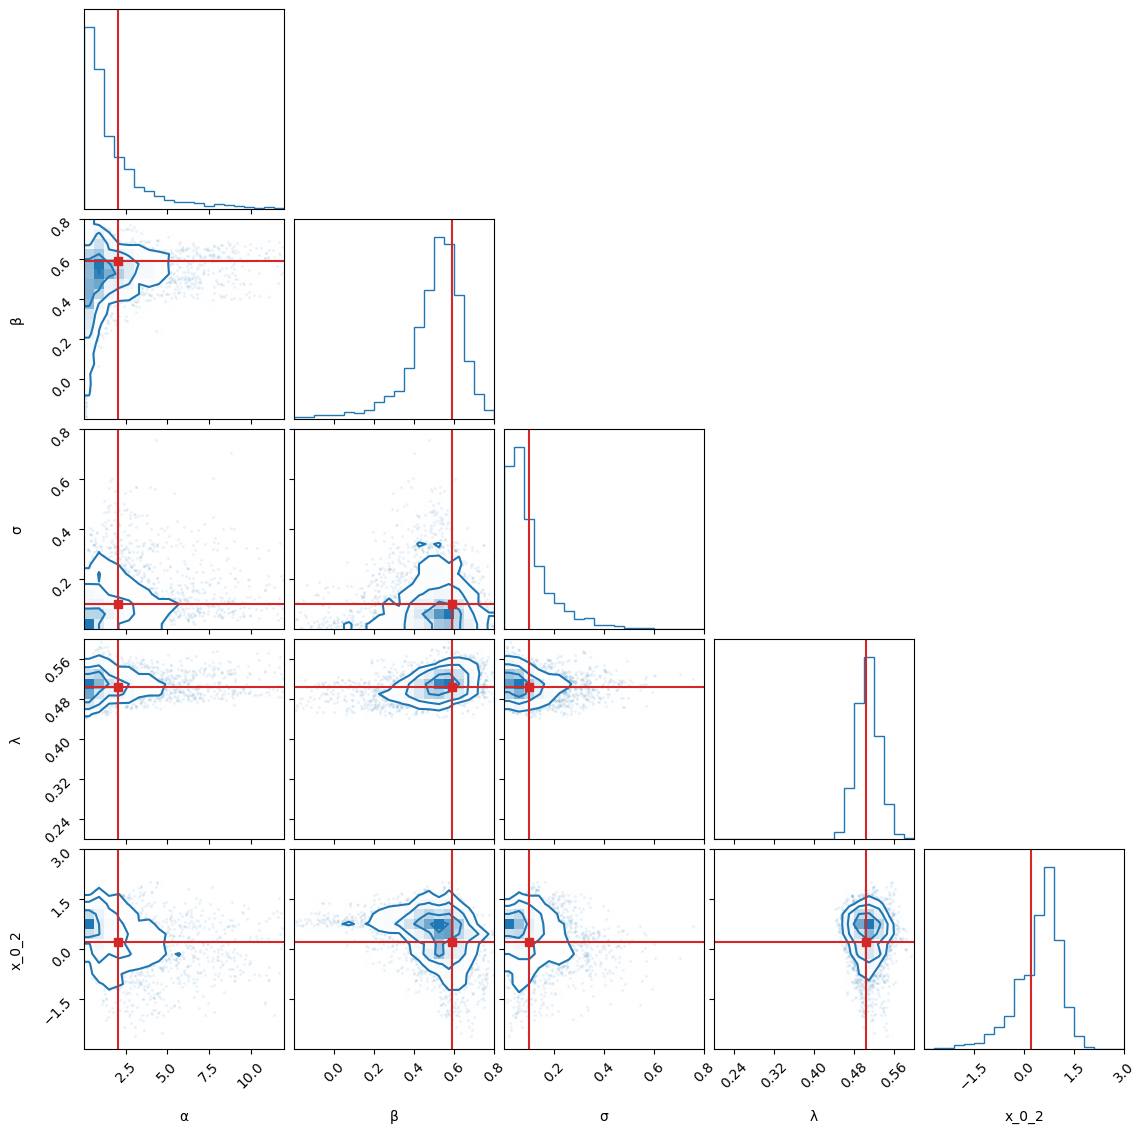

weak_order_2
0.08


Sampling stage: Adaptive warm up [06:36] > Main non-adaptive [14:17]

Chain 1/4: 100%|██████████|1000/1000 [03:35<00:00, 4.63it/s, n_step=1.02e+03, accept_stat=0.881]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [03:34<00:00, 4.66it/s, n_step=1.02e+03, accept_stat=0.855]

Chain 3/4: 100%|██████████|1000/1000 [03:33<00:00, 4.67it/s, n_step=1.01e+03, accept_stat=0.846]

Chain 4/4: 100%|██████████|1000/1000 [03:32<00:00, 4.70it/s, n_step=1.01e+03, accept_stat=0.828]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.939,2.237,0.057,6.234,0.260,0.184,34.0,220.0,1.09
β,0.523,0.155,0.191,0.776,0.026,0.018,46.0,140.0,1.08
σ,0.100,0.141,0.001,0.306,0.020,0.015,53.0,42.0,1.04
λ,0.492,0.019,0.458,0.528,0.002,0.002,81.0,271.0,1.03
x_0_2,0.421,0.632,-0.884,1.381,0.157,0.113,18.0,135.0,1.17


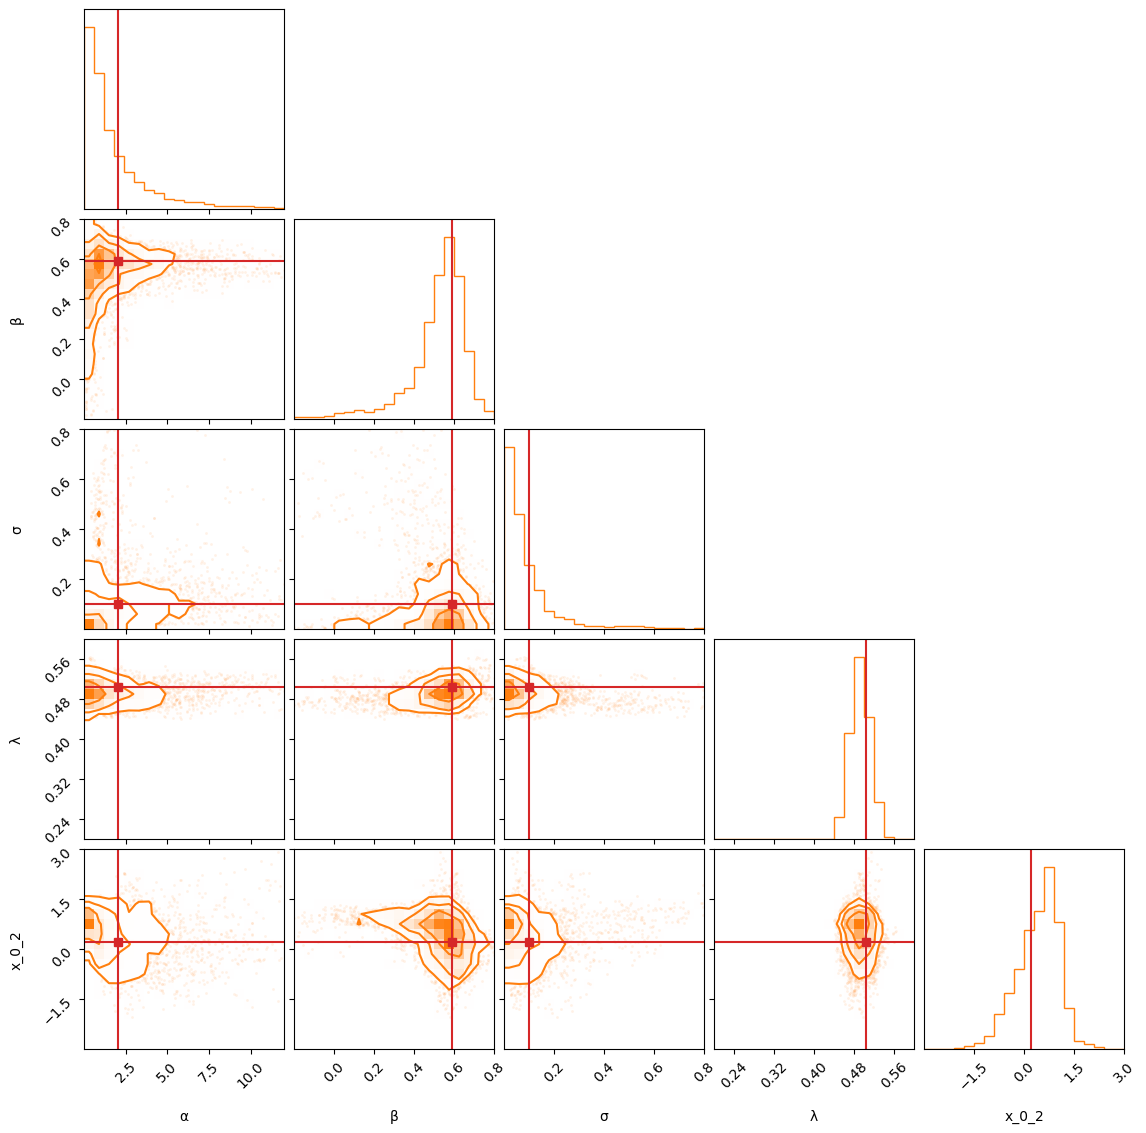

euler_maruyama
0.06


Sampling stage: Adaptive warm up [04:02] > Main non-adaptive [09:17]

Chain 1/4: 100%|██████████|1000/1000 [02:19<00:00, 7.15it/s, n_step=1.02e+03, accept_stat=0.942]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:19<00:00, 7.14it/s, n_step=1.02e+03, accept_stat=0.925]

Chain 3/4: 100%|██████████|1000/1000 [02:18<00:00, 7.23it/s, n_step=1.01e+03, accept_stat=0.894]

Chain 4/4: 100%|██████████|1000/1000 [02:18<00:00, 7.20it/s, n_step=1.02e+03, accept_stat=0.947]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.532,1.810,0.028,3.947,0.222,0.158,18.0,86.0,1.19
β,0.470,0.189,0.102,0.714,0.037,0.027,29.0,77.0,1.11
σ,0.116,0.160,0.002,0.435,0.034,0.024,26.0,32.0,1.16
λ,0.501,0.019,0.467,0.538,0.002,0.002,65.0,68.0,1.04
x_0_2,0.562,0.627,-0.655,1.742,0.139,0.100,21.0,56.0,1.13


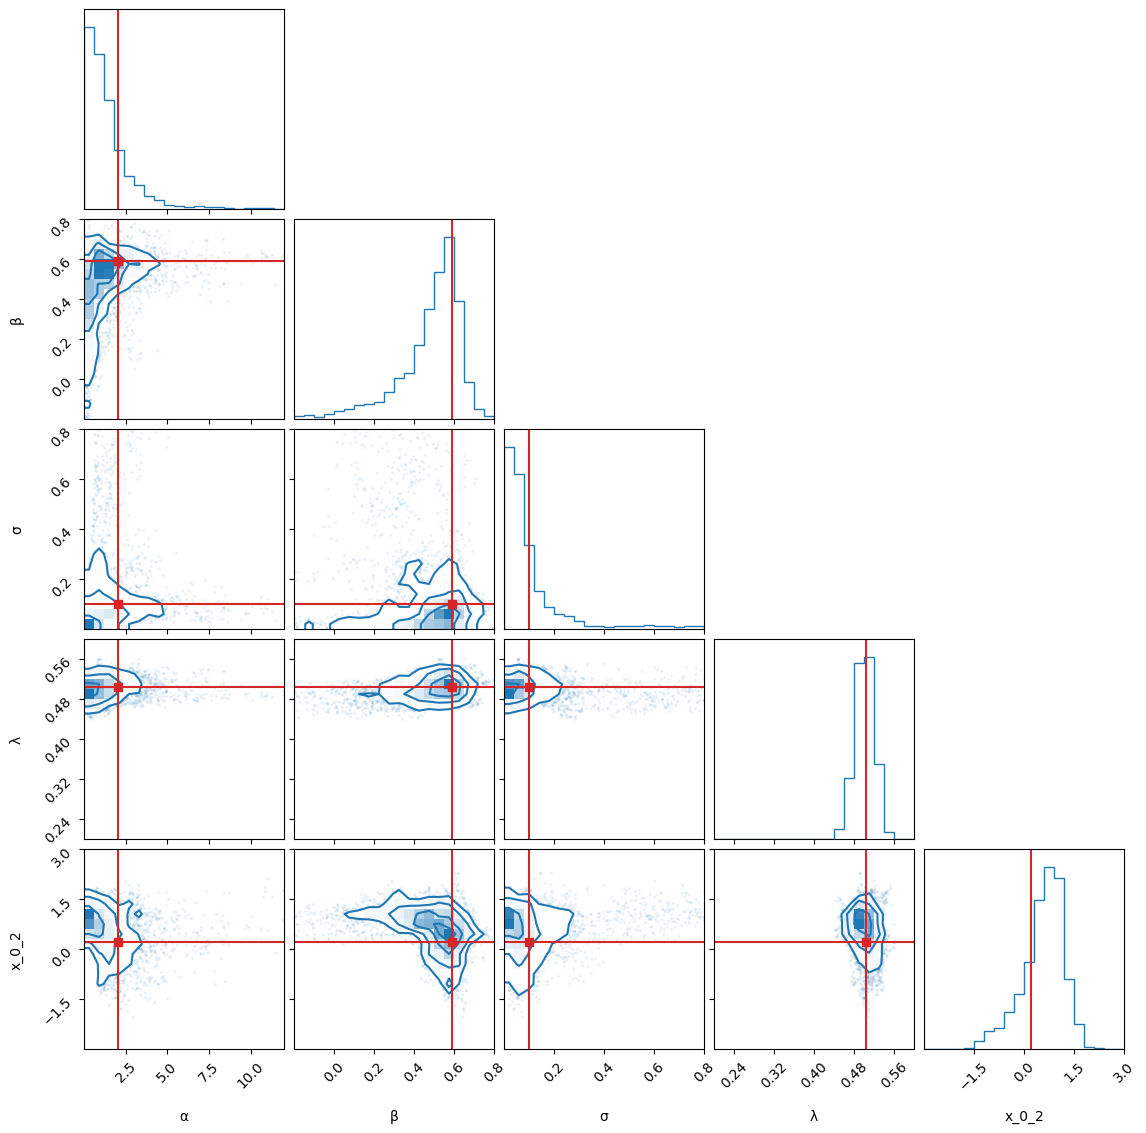

weak_order_2
0.06


Sampling stage: Adaptive warm up [08:13] > Main non-adaptive [17:36]

Chain 1/4: 100%|██████████|1000/1000 [04:25<00:00, 3.77it/s, n_step=1.02e+03, accept_stat=0.880]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [04:21<00:00, 3.82it/s, n_step=1.01e+03, accept_stat=0.837]

Chain 3/4: 100%|██████████|1000/1000 [04:24<00:00, 3.78it/s, n_step=1.02e+03, accept_stat=0.867]

Chain 4/4: 100%|██████████|1000/1000 [04:24<00:00, 3.78it/s, n_step=1.02e+03, accept_stat=0.845]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.047,2.151,0.057,6.138,0.221,0.157,68.0,175.0,1.04
β,0.528,0.167,0.231,0.740,0.016,0.011,99.0,208.0,1.05
σ,0.130,0.151,0.002,0.384,0.022,0.015,42.0,93.0,1.08
λ,0.492,0.019,0.455,0.527,0.002,0.001,93.0,204.0,1.04
x_0_2,0.497,0.719,-0.862,1.794,0.081,0.058,80.0,137.0,1.03


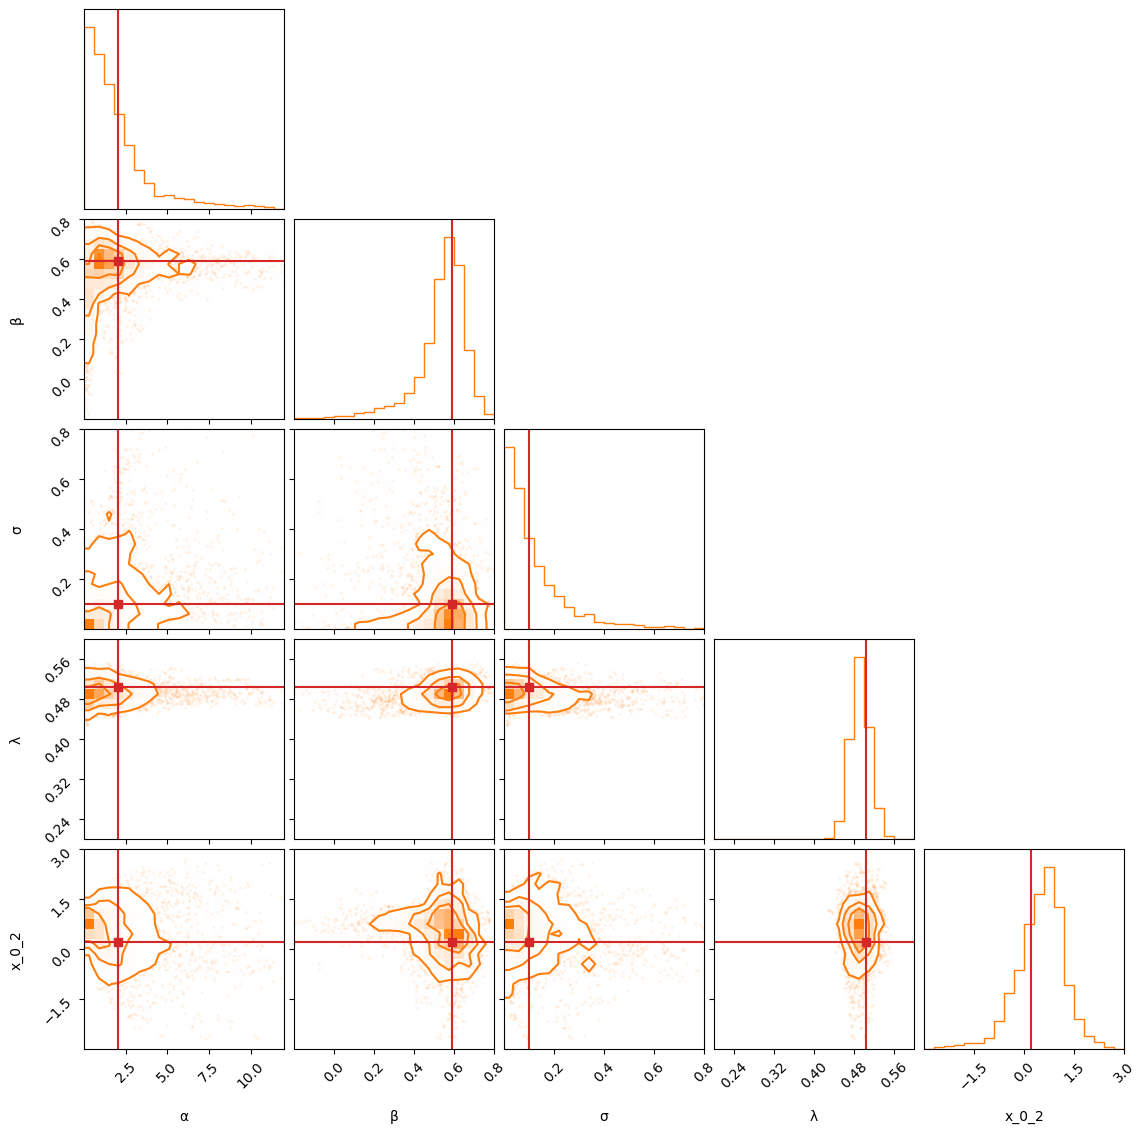

euler_maruyama
0.05


Sampling stage: Adaptive warm up [04:28] > Main non-adaptive [07:27]

Chain 1/4: 100%|██████████|1000/1000 [00:03<00:00, 316.03it/s, n_step=5.96, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:27<00:00, 6.79it/s, n_step=1.01e+03, accept_stat=0.854]

Chain 3/4: 100%|██████████|1000/1000 [02:28<00:00, 6.73it/s, n_step=1.02e+03, accept_stat=0.920]

Chain 4/4: 100%|██████████|1000/1000 [02:28<00:00, 6.74it/s, n_step=1.02e+03, accept_stat=0.893]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.148,1.421,0.058,3.276,0.245,0.174,31.0,78.0,1.20
β,0.459,0.177,0.124,0.660,0.021,0.015,65.0,160.0,1.13
σ,0.088,0.117,0.002,0.302,0.033,0.024,9.0,47.0,1.35
λ,0.482,0.016,0.448,0.511,0.003,0.002,23.0,118.0,1.12
x_0_2,0.686,0.705,-0.789,1.424,0.238,0.191,8.0,61.0,1.47


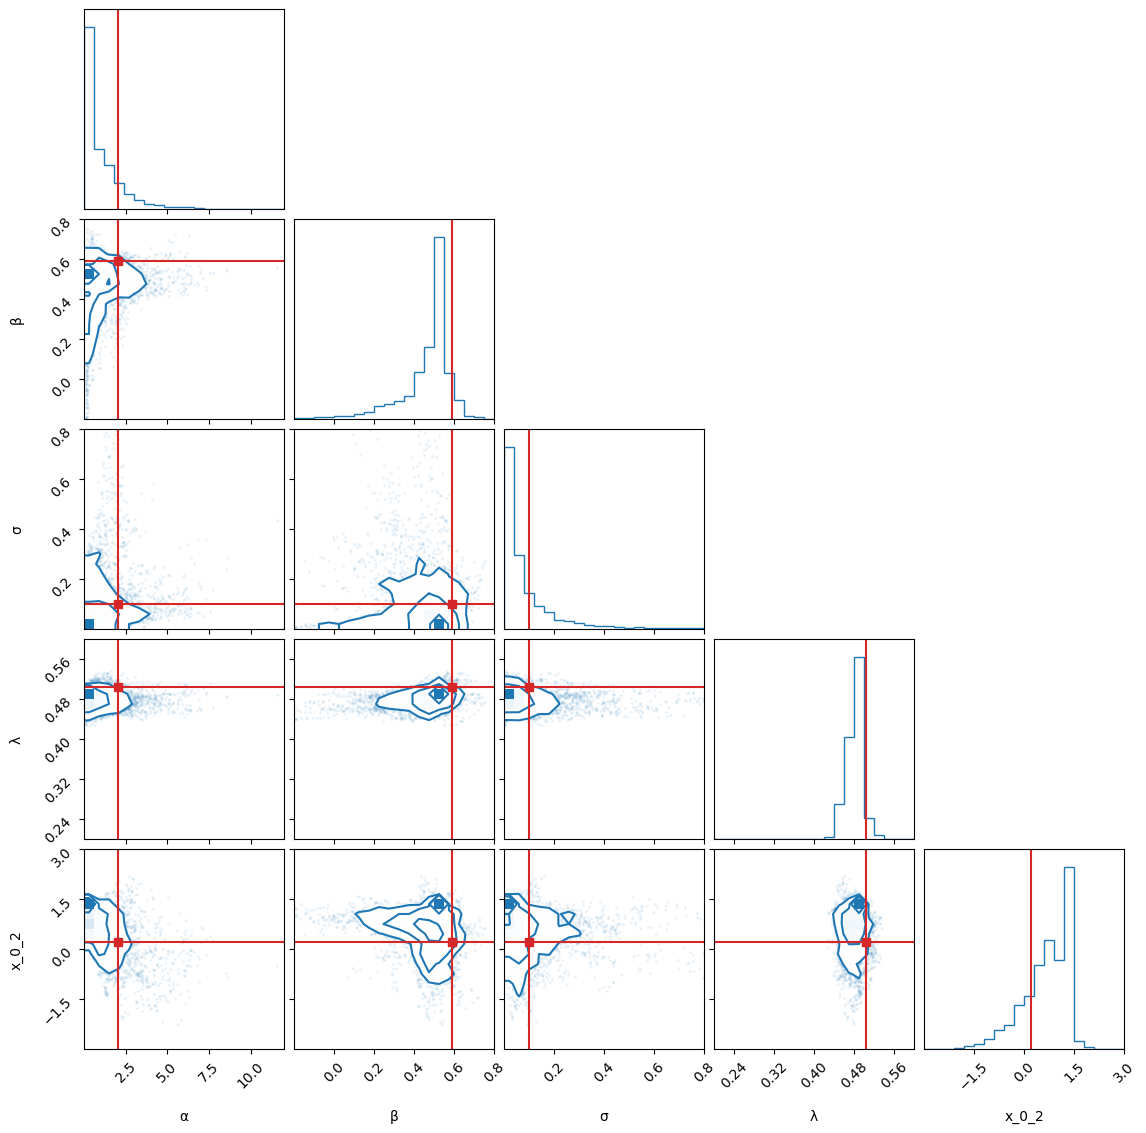

weak_order_2
0.05


Sampling stage: Adaptive warm up [09:19] > Main non-adaptive [20:10]

Chain 1/4: 100%|██████████|1000/1000 [05:02<00:00, 3.31it/s, n_step=1.01e+03, accept_stat=0.824]

Chain 2/4: 100%|██████████|1000/1000 [05:04<00:00, 3.29it/s, n_step=1.02e+03, accept_stat=0.883]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [05:00<00:00, 3.33it/s, n_step=1.01e+03, accept_stat=0.855]

Chain 4/4: 100%|██████████|1000/1000 [05:04<00:00, 3.29it/s, n_step=1.02e+03, accept_stat=0.855]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.659,1.932,0.037,4.808,0.423,0.304,13.0,46.0,1.26
β,0.468,0.168,0.148,0.711,0.024,0.018,38.0,161.0,1.09
σ,0.149,0.188,0.003,0.424,0.030,0.021,22.0,55.0,1.13
λ,0.469,0.018,0.438,0.507,0.002,0.002,61.0,193.0,1.06
x_0_2,0.466,0.687,-0.919,1.656,0.080,0.057,70.0,146.0,1.07


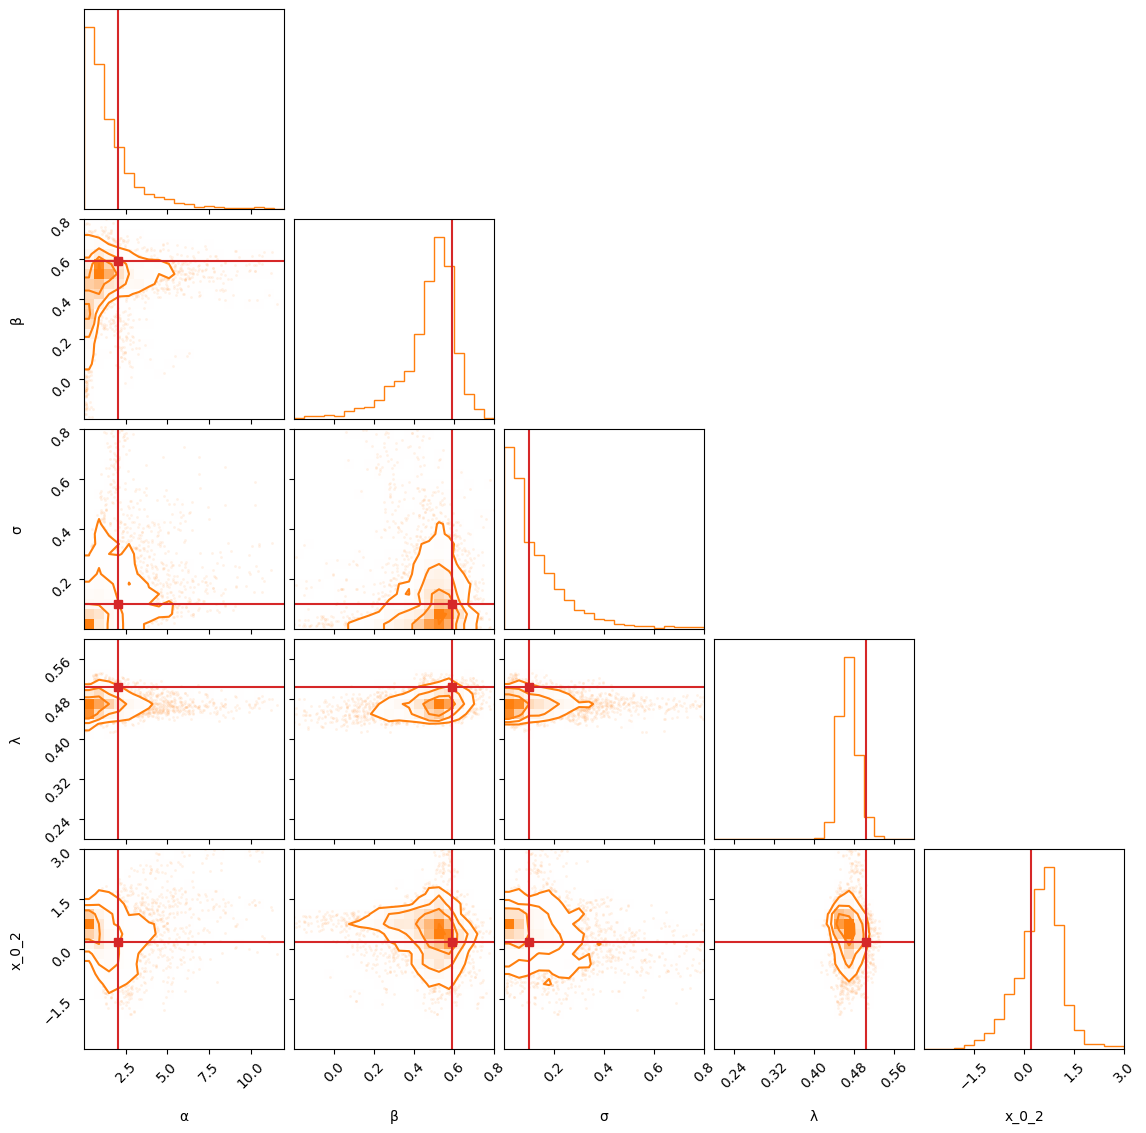

euler_maruyama
0.04


Sampling stage: Adaptive warm up [04:55] > Main non-adaptive [10:11]

Chain 1/4: 100%|██████████|1000/1000 [02:42<00:00, 6.14it/s, n_step=1.02e+03, accept_stat=0.892]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:05<00:00, 7.97it/s, n_step=1.02e+03, accept_stat=0.887]

Chain 3/4: 100%|██████████|1000/1000 [02:40<00:00, 6.22it/s, n_step=1.02e+03, accept_stat=0.859]

Chain 4/4: 100%|██████████|1000/1000 [02:42<00:00, 6.15it/s, n_step=1.01e+03, accept_stat=0.849]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.989,2.281,0.046,5.875,0.612,0.442,11.0,56.0,1.27
β,0.467,0.181,0.095,0.709,0.022,0.016,56.0,122.0,1.05
σ,0.102,0.133,0.001,0.302,0.021,0.015,31.0,45.0,1.11
λ,0.479,0.018,0.445,0.514,0.002,0.002,70.0,238.0,1.04
x_0_2,0.481,0.731,-0.991,1.798,0.126,0.090,38.0,105.0,1.10


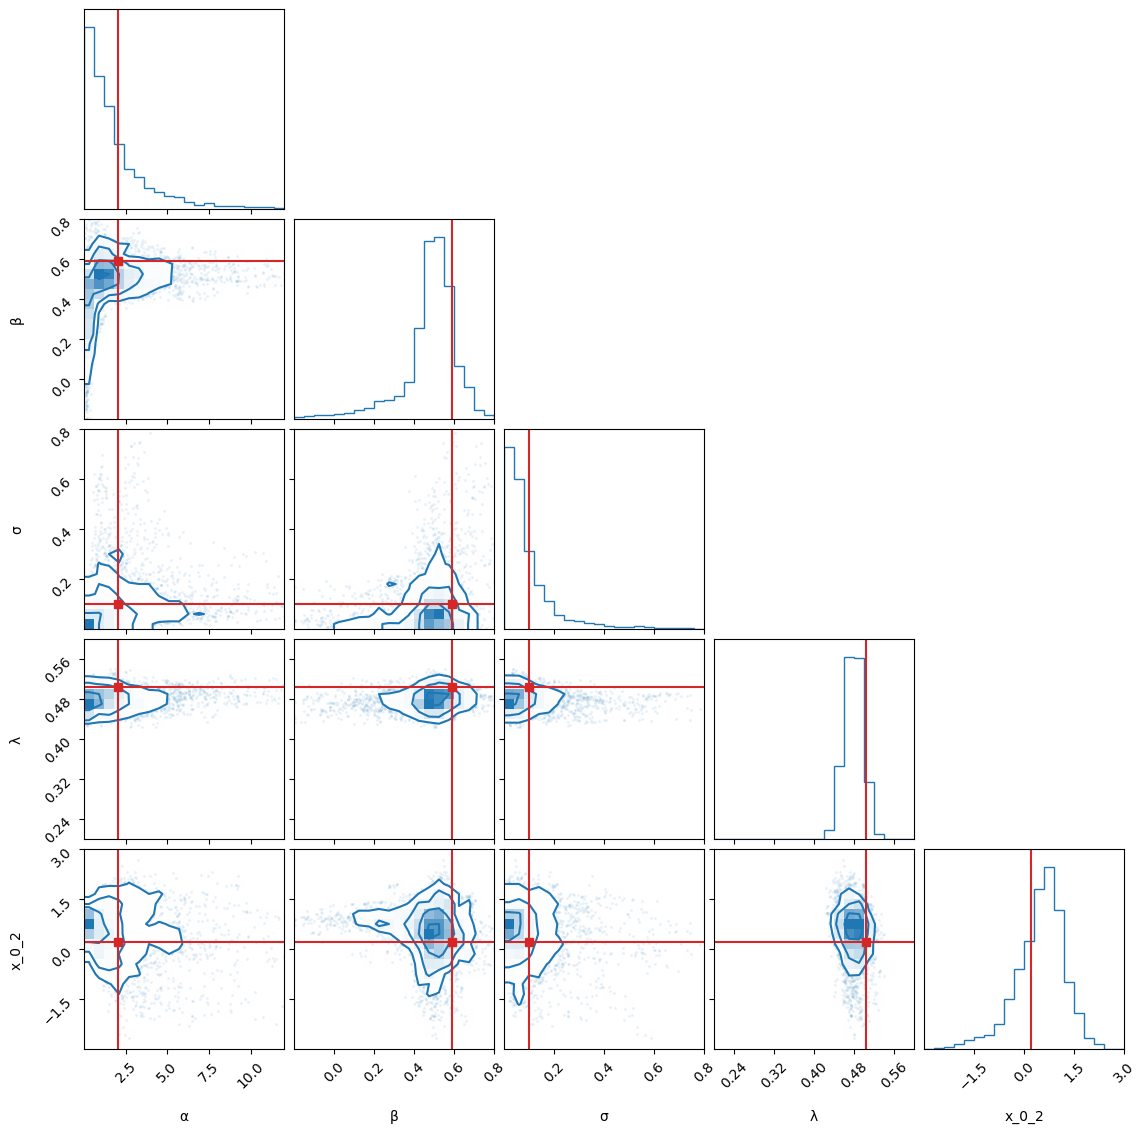

weak_order_2
0.04


Sampling stage: Adaptive warm up [10:27] > Main non-adaptive [11:33]

Chain 1/4: 100%|██████████|1000/1000 [05:43<00:00, 2.91it/s, n_step=1.02e+03, accept_stat=0.949]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [00:02<00:00, 372.54it/s, n_step=1.00, accept_stat=0.00]

Chain 3/4: 100%|██████████|1000/1000 [05:45<00:00, 2.90it/s, n_step=1.02e+03, accept_stat=0.976]

Chain 4/4: 100%|██████████|1000/1000 [00:02<00:00, 359.95it/s, n_step=1.27, accept_stat=0.00]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.414,0.677,0.033,1.658,0.226,0.165,5.0,11.0,2.40
β,-0.902,1.429,-2.988,0.588,0.708,0.545,5.0,10.0,3.15
σ,0.041,0.034,0.007,0.115,0.010,0.007,18.0,46.0,2.04
λ,0.451,0.021,0.429,0.489,0.009,0.007,5.0,4.0,2.25
x_0_2,1.050,0.496,0.329,1.774,0.216,0.178,6.0,95.0,2.07


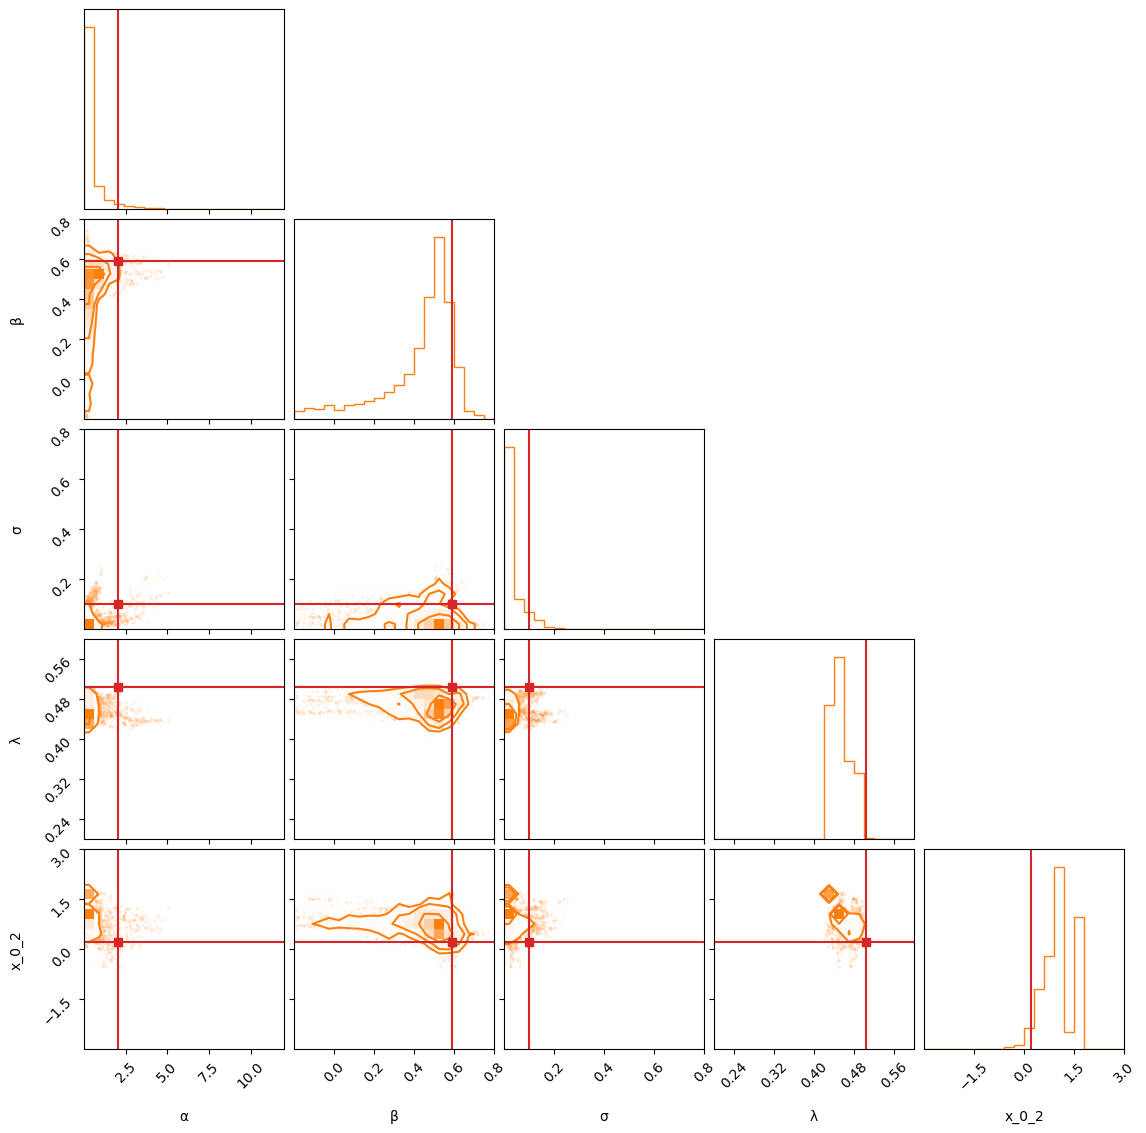

euler_maruyama
0.025


Sampling stage: Adaptive warm up [06:21] > Main non-adaptive

Chain 1/4:  39%|████      |395/1000 [01:22<02:06, 4.78it/s, n_step=1.02e+03, accept_stat=0.875]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [01:36<00:00, 5.17it/s, n_step=957., accept_stat=0.802]

Chain 3/4: 100%|██████████|500/500 [01:36<00:00, 5.17it/s, n_step=959., accept_stat=0.800]

Chain 4/4: 100%|██████████|500/500 [01:34<00:00, 5.29it/s, n_step=936., accept_stat=0.803]

ERROR:mici.samplers:Sampling manually interrupted for chain 1 at iteration 395. Arrays containing chain traces and statistics computed before interruption will be returned.
Shape validation failed: input_shape: (1, 395), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.418,1.333,0.151,4.016,0.322,0.231,15.0,30.0,NaN
β,0.529,0.167,0.271,0.920,0.040,0.029,8.0,22.0,NaN
σ,0.177,0.141,0.016,0.449,0.104,0.090,2.0,30.0,NaN
λ,0.475,0.017,0.439,0.501,0.004,0.003,17.0,13.0,NaN
x_0_2,0.027,0.715,-1.437,1.089,0.205,0.149,15.0,31.0,NaN


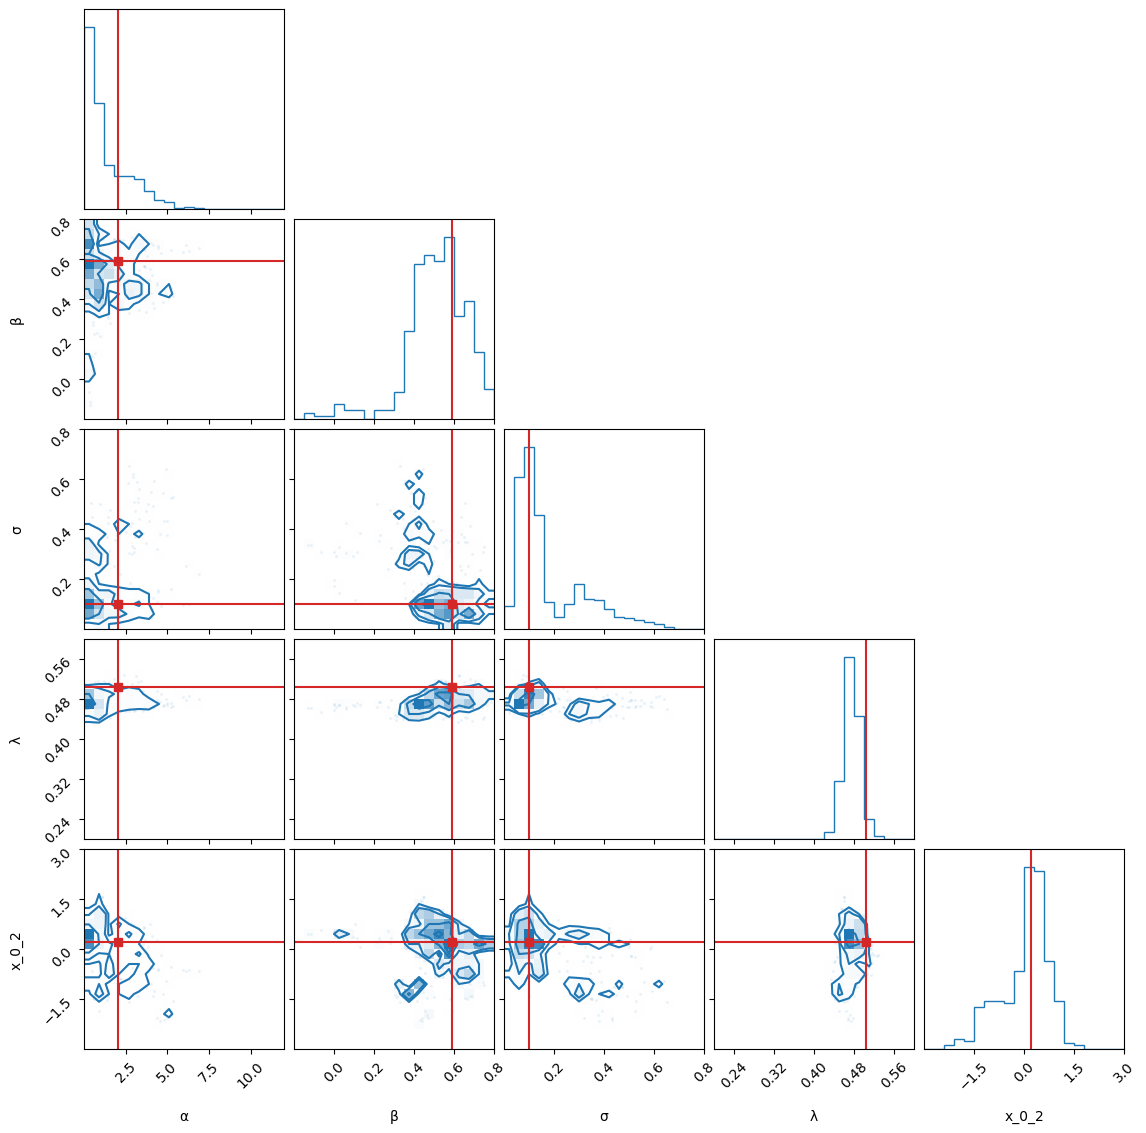

weak_order_2
0.025


Sampling stage: Adaptive warm up

Chain 1/4:   5%|▋         |28/500 [00:11<03:08, 2.50it/s, n_step=721., accept_stat=0.779]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)
ERROR:mici.samplers:Sampling manually interrupted for chain 1 at iteration 28. Arrays containing chain traces and statistics computed before interruption will be returned.


ValueError: Can not extract posterior from {}! See /Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/arviz/data/converters.py for other conversion utilities.

In [8]:
n_chain = 4
#n_warm_up_iter = 1000
n_warm_up_iter = 500
n_main_iter = 1000
dt_inference_seq = np.array([0.01])
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        #dt_inference = 200 * dt_simulation
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 5,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20221111)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            bins = 100, 
            range = [(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)], 
            #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
            color=f'C{color}',
            #truth_color="C3"
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1


In [ ]:
for color in range(2):
    for i in range(dt_inference_seq.size):
        fig = corner.corner(trace[color][i], 
                    range = [(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)], 
                    bins=30,
                    #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
                    color=f'C{color}'
                )
        display(fig)
        plt.close(fig)